In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..') # Add python files from main folder in PYTHON path
import utils
%matplotlib inline

## Utils

In [2]:
def Patch(image, i, j, m):
    """ Returns a m x m patch taken from Image, centered at coordinates i,j """
    patch = image[:, :, i-m:i+m+1, j-m:j+m+1]
    return patch

In [3]:
def valid(coord, coord_limit, m):
    """ Makes sure the coordinates lie in a valid range (m corrects for the zero-padding) """
    coord = max(coord, m)
    coord = min(coord, coord_limit + m - 1)
    
    return coord

In [4]:
def warp(B, NNF_ab):
    """ Warp exprimes the content of image A but only with pixels sampled from image B """
    Warp = B[:, NNF_ab[0,:,:], NNF_ab[1,:,:]]
    
    return Warp

## Similarity Metrics

In [5]:
def euclideanDistance(P1, P2):
    """ Returns the squared euclidean distance between two patches """
    distance = torch.sum((P1 - P2) ** 2)
    return distance

## PatchMatch

In [6]:
def initializeNNF(h, w):
    """ 
    Randomly initializes NNF_ab
    - NNF_ab[:,i,j] is a 2D vector representing the coordinates x,y 
      so that B[0,:,x,y] is most similar to A[0,:,i,j] 
    """
    # Instanciates NNF_ab
    NNF_ab = np.zeros(shape=(2,h,w), dtype=np.int)
    
    # Fill in NNF_ab[:,:,0] contains the coordinates x (row)
    NNF_ab[0,:,:] = np.random.randint(low=0, high=h, size=(h,w))
        
    # Fill in NNF_ab[:,:,1] contains the coordinates y (column)
    NNF_ab[1,:,:] = np.random.randint(low=0, high=w, size=(h,w))
    
    # Turns it into an autograd.Variable and send it on the GPU
    if torch.cuda.is_available() and False:
        NNF_ab = Variable(torch.from_numpy(NNF_ab)).cuda()
    else:
        NNF_ab = Variable(torch.from_numpy(NNF_ab))
    
    return NNF_ab

In [7]:
def propagate(A, B, h, w, NNF_ab, i, j, shift):
    # Patch half-size
    m = int((config['patch_size'] - 1) / 2)

    # Extract the patch at coordinates i,j in A
    A_patch = Patch(A,i,j,m)
    
    # Extract the patch-match in B associated with current position
    A_current_patchMatch = Patch(B, NNF_ab[0,i,j], NNF_ab[1,i,j], m)
    
    # Computes the distance between current patch
    current_match = euclideanDistance(A_patch, A_current_patchMatch)

    if config['propagation_mode'] == 'NM':
    
        # Extract the patch-match in B associated with left neighbor and up neighbor in A
        A_leftNeighbor_patchMatch = Patch(B, 
                                          NNF_ab[0,i,valid(j+shift,w,m)], 
                                          NNF_ab[1,i,valid(j+shift,w,m)], 
                                          m)
        
        A_upNeighbor_patchMatch = Patch(B, 
                                        NNF_ab[0,valid(i+shift,h,m),j], 
                                        NNF_ab[1,valid(i+shift,h,m),j], 
                                        m)

        # Computes the distance between potential matches
        left_neighbor_match = euclideanDistance(A_patch, A_leftNeighbor_patchMatch)
        up_neighbor_match = euclideanDistance(A_patch, A_upNeighbor_patchMatch)

        # Looks up which match is the best. If best match is current match, nothing is changed
        best_match = np.argmin(np.array([current_match, left_neighbor_match, up_neighbor_match]))
  
        if best_match == 1:
            # New patch-match in B is the same than for left-neighbor in A
            NNF_ab[:,i,j] = NNF_ab[:,i,valid(j+shift,w,m)]

        if best_match == 2:
            # New patch-match in B is the same than for up-neighbor in A
            NNF_ab[:,i,j] = NNF_ab[:,valid(i+shift,h,m),j]
        
        
    elif config['propagation_mode'] == 'NoNM':
    
        # Extract the patch-match in B associated with left neighbor and up neighbor in A
        RN_PM_LN = Patch(B, 
                         NNF_ab[0,i,valid(j+shift,w,m)], 
                         valid(NNF_ab[1,i,valid(j+shift,w,m)]-shift,w,m), 
                         m)
        
        DP_PM_UP = Patch(B, 
                         valid(NNF_ab[0,valid(i+shift,h,m),j]-shift,h,m), 
                         NNF_ab[1,valid(i+shift,h,m),j], 
                         m)

        # Computes the distance between potential matches
        left_neighbor_match = euclideanDistance(A_patch, RN_PM_LN)
        up_neighbor_match = euclideanDistance(A_patch, DP_PM_UP)

        # Looks up which match is the best. If best match is current match, nothing is changed
        best_match = np.argmin(np.array([current_match, left_neighbor_match, up_neighbor_match]))        
        
        if best_match == 1:
            # New patch-match in B based on left-neighbor's match
            NNF_ab[0,i,j] = NNF_ab[0,i,valid(j+shift,w,m)]
            NNF_ab[1,i,j] = valid(NNF_ab[1,i,valid(j+shift,w,m)]-shift,w,m)

        if best_match == 2:
            # New patch-match in B based on up-neighbor's match
            NNF_ab[0,i,j] = valid(NNF_ab[0,valid(i+shift,h,m),j]-shift,h,m)
            NNF_ab[1,i,j] = NNF_ab[1,valid(i+shift,h,m),j]
     

    return NNF_ab

In [8]:
def randomSearch(A, B, h, w, NNF_ab, i, j):
    # Patch half-size
    m = int((config['patch_size'] - 1) / 2)

    max_step = config['random_search_max_step']

    for k in range(config['number_of_patches_per_zone']):
        # Makes sure we sample our random step to end up in a valid coordinate (within the image)
        max_up_step = min(i - m, max_step)
        max_down_step = min(h + m - 1 - i, max_step)
        max_left_step = min(j - m, max_step)
        max_right_step = min(w + m - 1 - j, max_step)

        # The randomly sampled coordinates for the random patch-match
        [x, y] = NNF_ab[:,i,j].numpy() + np.concatenate((np.random.randint(low=-max_up_step, high=max_down_step, size=(1,)), 
                                                         np.random.randint(low=-max_left_step, high=max_right_step, size=(1,))))

        # Makes sure that those coordinates lie within the limits of our image
        x = valid(x, h, m)
        y = valid(y, w, m)

        # Extract the patch around our current position in A
        A_patch = Patch(A,i,j,m)

        # Extract current patch-match and random patch-match in B
        A_current_patchMatch = Patch(B, NNF_ab[0,i,j], NNF_ab[1,i,j], m)
        A_random_patchMatch = Patch(B, x, y, m)

        # Computes how good both matches are
        current_match = euclideanDistance(A_patch, A_current_patchMatch)
        random_match = euclideanDistance(A_patch, A_random_patchMatch)

        # Looks up which match is the best. If best match is current match, nothing is changed
        best_match = np.argmin(np.array([current_match, random_match]))

        if best_match == 1:
            NNF_ab[:,i,j] = torch.from_numpy(np.array([x,y]))
                    
    return NNF_ab

In [24]:
def PatchMatch(image1, image2):
    """
    Computes the NNF function between image1 and image 2
    image 1 : an autograd.Variable of shape [batch, channels, heigth, width]
    image 2 : an autograd.Variable of shape [batch, channels, heigth, width]
    """
    
    # Makes sure the two images have the same size
    if image1.size() != image2.size():
        raise ValueError("The two images must have the same size.")
    
    # Heigth and Width of images
    [h,w] = image1.size()[2:]
     
    # Patch half-size
    m = int((config['patch_size'] - 1) / 2)
    
    # Randomly initializes NNF_ab
    NNF_ab = initializeNNF(h,w)
    
    # Zero-Pad images
    #A = F.pad(image1, (m,m,m,m), mode='constant', value=0).data.float()
    #B = F.pad(image2, (m,m,m,m), mode='constant', value=0).data.float()

    A = F.pad(image1, (m,m,m,m), mode='reflect').data.float()
    B = F.pad(image2, (m,m,m,m), mode='reflect').data.float()
    
    # Zero-Pad NNF_ab so its coordinate system as well as the values it contains remains consistent with images A and B
    NNF_ab += m
    NNF_ab = torch.squeeze(F.pad(NNF_ab.unsqueeze(0), (m,m,m,m), mode='constant', value=0)).data
    
    # Executes the PatchMatch algorithm n_iter times
    for step in range(config['n_iter']):
        print("Iteration {0} -----".format(step+1))
        if step%2 == 0:
            shift = -1

            # Defines valid ranges (exclude the padded indexes)
            i_range = np.arange(h) + m
            j_range = np.arange(w) + m
        
        else:
            shift = 1

            # Defines valid ranges (exclude the padded indexes)
            i_range = np.arange(h) + m
            j_range = np.arange(w) + m

            i_range = i_range[::-1]
            j_range = j_range[::-1]
        
        # For every valid pixel in the image
        for i in i_range:
            if (i+1)%100 == 0 : print("Row : {0}".format(i+1))
            for j in j_range:
                NNF_ab = propagate(A, B, h, w, NNF_ab, i, j, shift)
                NNF_ab = randomSearch(A, B, h, w, NNF_ab, i, j)
    
    NNF_final = NNF_ab[:, m:-m, m:-m]
    NNF_final -= m
    
    print("Done!")
    
    return NNF_final

## Demo on Images

Images on CPU
Iteration 1 -----
Row : 100
Row : 200
Row : 300
Row : 400
Row : 500
Row : 600
Done!


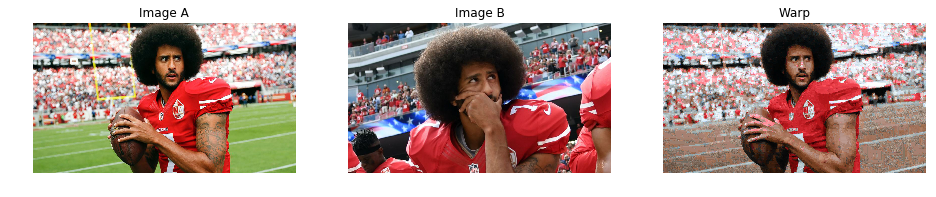

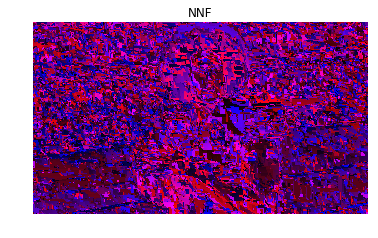

In [29]:
config = {}
config['patch_size'] = 3 # For PatchMatch
config['number_of_patches_per_zone'] = 1
config['n_iter'] = 1
config['propagation_mode'] = 'NoNM' # 'NoNM'(Neighbor of Neighbor's Match) or 'NM'(Neighbor's Match)
config['random_search_max_step'] = 400

# Load the images
im1 = plt.imread(os.path.join("..", "Images", "kapernick1.jpg"))
im2 = plt.imread(os.path.join("..", "Images", "kapernick2.jpg"))

# Chagne images shape from [heigth, width, channels] to [channels, heigth, width]
imgs = [np.transpose(im1, axes=(2,0,1)), np.transpose(im2, axes=(2,0,1))]

# Turns them into autograd.Variables and send them on GPU (if available) and add a batch dimension
if torch.cuda.is_available() and False:
    print("Images on GPU")
    imgs_torch = [Variable(torch.from_numpy(img).unsqueeze(0).cuda()) for img in imgs]
else:
    print("Images on CPU")
    imgs_torch = [Variable(torch.from_numpy(img).unsqueeze(0).float()) for img in imgs]

# Runs the PatchMatch algorithm
NNF_ab = PatchMatch(imgs_torch[0], imgs_torch[1])

# Reconverting NNF_ab to a ndarray of shape [heigth, width, channels]
NNF = np.transpose(NNF_ab.numpy(), axes=(1,2,0))

# Displays the original images and resulting Warp
plt.figure(figsize=(16, 12))
plt.subplot(131)
plt.imshow(im1)
plt.title("Image A")
plt.axis("off")

plt.subplot(132)
plt.imshow(im2)
plt.title("Image B")
plt.axis("off")

plt.subplot(133)
plt.imshow(im2[NNF[:,:,0], NNF[:,:,1], :])
plt.title("Warp")
plt.axis("off")
plt.show()


plt.imsave("im1.png", im1)
plt.imsave("im2.png", im2)
plt.imsave("Warp.png", im2[NNF[:,:,0], NNF[:,:,1], :])

# Displays the NNF (mapping function)
zer = np.zeros(shape=(NNF.shape[0], NNF.shape[1], 1), dtype=NNF.dtype)
colorNNF = np.concatenate((np.expand_dims(NNF[:,:,0], 2), zer, np.expand_dims(NNF[:,:,1], 2)), axis=2)

plt.imshow(colorNNF.astype(np.uint8))
plt.title("NNF")
plt.axis("off")
plt.show()

## Demo on featureMaps

In [ ]:
L = 5
F1 = "A2"
F2 = "B1"

config = {}
config['patch_size'] = 3 # For PatchMatch
config['number_of_patches_per_zone'] = 15
config['n_iter'] = 5
config['propagation_mode'] = 'NoNM' # 'NoNM'(Neighbor of Neighbor's Match) or 'NM'(Neighbor's Match)
config['random_search_max_step'] = 16

# Displays the feature Maps
FM_1 = utils.loadFeatureMaps(os.path.join('..', 'Results', 'featureMaps_' + F1 + '.pkl'))
FM_2 = utils.loadFeatureMaps(os.path.join('..', 'Results', 'featureMaps_' + F2 + '.pkl'))

# Chagne images shape from [heigth, width, channels] to [channels, heigth, width]
FMs = [np.transpose(FM_1[L], axes=(2,0,1)), np.transpose(FM_2[L], axes=(2,0,1))]

# Turns them into autograd.Variables and send them on GPU (if available) and add a batch dimension
if torch.cuda.is_available() and False:
    print("Images on GPU")
    FMs_torch = [Variable(torch.from_numpy(fm).unsqueeze(0).cuda()) for fm in FMs]
else:
    print("Images on CPU")
    FMs_torch = [Variable(torch.from_numpy(fm).unsqueeze(0)) for fm in FMs]

# Runs the PatchMatch algorithm
NNF_ab = PatchMatch(FMs_torch[0], FMs_torch[1])

# Reconverting NNF_ab to a ndarray of shape [heigth, width, channels]
NNF = np.transpose(NNF_ab.numpy(), axes=(1,2,0))

# Displays the original images and resulting Warp
plt.figure(figsize=(16, 12))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(FM_1[L][:,:,i], cmap='gray')
    plt.title("FM_{0}[{1}][:,:,{2}]".format(F1, L, i))
    plt.axis("off")
plt.show()

plt.figure(figsize=(16, 12))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(FM_2[L][:,:,i], cmap='gray')
    plt.title("FM_{0}[{1}][:,:,{2}]".format(F2, L, i))
    plt.axis("off")
plt.show()

plt.figure(figsize=(16, 12))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(FM_2[L][NNF[:,:,0], NNF[:,:,1], i], cmap='gray')
    plt.title("Warp[:,:,{0}]".format(i))
    plt.axis("off")
plt.show()


# Displays the NNF (mapping function)
zer = np.zeros(shape=(NNF.shape[0], NNF.shape[1], 1), dtype=NNF.dtype)
colorNNF = np.concatenate((np.expand_dims(NNF[:,:,0], 2), zer, np.expand_dims(NNF[:,:,1], 2)), axis=2)
colorNNF = ((colorNNF - float(np.max(colorNNF))) / (float(np.max(colorNNF)) - float(np.min(colorNNF)))) * 255

plt.imshow(colorNNF.astype(np.uint8))
plt.title("NNF")
plt.axis("off")
plt.show()